In [237]:
#for each CSET AC down profile, we generate a backtrajectory (using ERA5 data!) and extract along it
#first, get all profiles
#second, adapt Ryan's code to run backtrajectory from a point
#third, extract along them

In [156]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))


import pandas as pd
import glob
import xlrd
import numpy as np
import datetime as dt
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.colors as colors
from uwtrajectory import met_utils
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec


from uwtrajectory.HYSPLIT import hysplit_utils as hysplit
from uwtrajectory import unified_traj_data as utd

%load_ext autoreload
%autoreload 2
print('booger')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
booger


In [2]:
def read_CSET_Lookup_Table(path=None, rf_num=None, sequences=None, legs=None, variables=None):
    """Read in data from the CSET Lookup Table.

    Arguments
    ----------
    path : str
        string representing the location of the lookup table
    rf_num : str or list, int
        list of integers of research flights, or 'all' for all flights
    legs : str or list, str
        list of strings representing the LEG NAMES for which variables should
        be retrieved, or 'all' for all variables
            b: below cloud
            c: in cloud
            a: above cloud
            p: porpoise
            m: Mather sounding
            k: Kona sounding
            f: ferry
            u: up sounding
            d: down sounding
    sequences : str or list, str
        list of strings representing the SEQUENCE NAMES for which variables should
        be retrieved, or 'all' for all defined sequences. first sequence of each flight
        is 'A', last is C-E depending on how many sequences were performed.
        NOTE: 'all' is NOT the same as leaving this as None (default). 'all' will
        explicitly look at all the sequences, so any upper-level data would be excluded.
        None will look only at rf_num and specified legs, ignoring sequences entirely.
    variables: list, str
        list of strings representing variables you want as list. leave blank to
        get error message with all options. Useful ones are 'Date', 'ST', 'ET'
        for date, start time, and end time
    Returns
    ----------
    ret_dict : dict
        dictionary with m+2 entries, where m is the number of requested vars:
            'rf': an array of length n the research flights
            'sequence': an array of length n of the sequences
            for each variable, a dictionary with units and a length n array
            of variable values

    """
    # warnings.warn("NOTE: usage change Feb 2018: sequences now refers to flight sequence (A,B,...) "
    #       "and legs refers to portion of flight ('b', 'p'), etc. see docstring")
    if path is None:
        path = r'/home/disk/eos4/jkcm/Data/CSET/LookupTable_all_flights.xls'
    sheet = xlrd.open_workbook(path).sheet_by_index(0)
    leg_colnum = np.argwhere(np.array(sheet.row_values(11)) == 'Leg Name').flatten()[0]
    all_legs = [str(i) for i in sheet.col_values(leg_colnum)[18:]]
    flight_colnum = np.argwhere(np.array(sheet.row_values(11)) == 'Research Flight Number').flatten()[0]
    all_flights = [int(i) for i in sheet.col_values(flight_colnum)[18:]]
    seq_colnum = np.argwhere(np.array(sheet.row_values(11)) == 'Sequence Name').flatten()[0]
    all_sequences = [str(i) for i in sheet.col_values(seq_colnum)[18:]]
    abb_cell = [str(i.value) for i in sheet.col_slice(0, 0, 10)]
    val_cell = [str(i.value) for i in sheet.col_slice(1, 0, 10)]
    varab = [str(i.value) for i in sheet.row_slice(12, 3, 39)]
    vname = [str(i.value).ljust(28) for i in sheet.row_slice(11, 3, 39)]
    vunit = [str(i.value).ljust(6) for i in sheet.row_slice(16, 3, 39)]

    if legs == 'all':
        legs = [str(i) for i in set(all_legs)]
    elif isinstance(legs, str):
        legs = [legs]
    if rf_num == 'all':
        rf_num = [i for i in set(all_flights)]
    elif isinstance(rf_num, int):
        rf_num = [rf_num]
    if sequences == 'all':
        sequences = [str(i) for i in set(all_sequences)]
    elif isinstance(sequences, str):
        sequences = [sequences]

    # if there is missing input, print some helpful information
    mess = "Missing or incorrect input, printing help"
    if rf_num is None or not set(rf_num) <= set(all_flights):
        mess += ("\n\nspecify the RESEARCH FLIGHTS (rf_num) you want as list."
                 "\noptions are {}".format(str([i for i in set(all_flights)])))
        mess += "\nor select 'all'"
    if legs is None or not set(legs) <= set(all_legs):
        abbs = ['{}: {}'.format(a, b) for (a, b) in zip(abb_cell, val_cell)]
        mess += ("\n\nspecify the LEG NAMES (legs) you want as list.\n"
                 "options are: \n{}".format('\n'.join(abbs)))
        mess += "\nor select 'all'"
    if sequences is not None and not set(sequences) <= set(all_sequences):
        mess += ("\n\neither leave SEQUENCE NAMES (seqs) blank to \n"
                 "ignore sequences, or else specify as list, or select 'all'")
    if variables is None or not set(variables) <= set(varab):
        var = ['{}{}{}'.format(a.ljust(14), b, c) for (a, b, c) in
               zip(varab, vname, vunit)]
        mess += ("\n\nspecify the VARIABLES (variables) you want as list.\n"
                 "options are: \n{}".format('\n'.join(var)))
    if len(mess) > 41:
        raise ValueError(mess)

    # otherwise return the requested values as a dict of dicts\
    rows, = np.where(
        [False]*18 + [True if (l in legs and f in rf_num) else False
                      for l, f in zip(all_legs, all_flights)])
    if sequences is not None:
        seqrows, = np.where(
            [False]*18 + [True if s in sequences else False
                          for s in all_sequences])
        rows = np.intersect1d(rows, seqrows)
    cols, = np.where(
        [False]*3 + [True if v in variables else False for v in varab])
    rf = np.array([int(sheet.cell(r, flight_colnum).value) for r in rows])
    leg = np.array([str(sheet.cell(r, leg_colnum).value) for r in rows])
    seq = np.array([str(sheet.cell(r, seq_colnum).value) for r in rows])

    ret_dict = {'rf': rf, 'leg': leg, 'seq': seq}
    for c in cols:
        varname = str(sheet.cell(12, c).value)
        units = str(sheet.cell(16, c).value)
        values = np.array([sheet.cell(r, c).value for r in rows])
        ret_dict[varname] = {'units': units, 'values': values}
    return ret_dict

def CSET_date_from_table(date, time):
    """return datetime object from CSET Lookup Table-formatted date and time
    """
    d = dt.datetime.strptime(str(int(date)), '%m%d%y') + dt.timedelta(seconds=time)
    return d

In [3]:
#first, get profiles
profiles = read_CSET_Lookup_Table(path=r'/home/disk/eos4/jkcm/Data/CSET/LookupTable_all_flights.xls', 
                        rf_num=[2, 4, 6, 8, 10, 12, 14], sequences=None, legs='d', variables=['Lat_S', 'Lon_S', 'Date', 'ST', 'ET'])
start_dates = [CSET_date_from_table(a,b) for (a,b) in zip(profiles['Date']['values'], profiles['ST']['values'])]
end_dates = [CSET_date_from_table(a,b) for (a,b) in zip(profiles['Date']['values'], profiles['ET']['values'])]
lats, lons = profiles['Lat_S']['values'], profiles['Lon_S']['values']

In [14]:
def run_ERA5_trajectory(lat, lon, time, direction, duration, save_name=None):
    return
#shortcut: hysplit
for lat, lon, date in zip(lats, lons, start_dates):
    print(date)
#     (analysis_list, analysis_date) = hysplit.get_GDAS_data(date)

#     historical_tdump = hysplit.write_control_file(start_time = date,
#                                           coords = [(lat, lon)],
#                                           hyfile_list = analysis_list,
#                                           hours = -2*24,
#                                           vertical_type = 1,  # isobaric
#                                           init_height = 500,
#                                           tdump_prefix='cset_profile_')
#     with open('/home/disk/p/jkcm/hylog', 'wb') as f:
#         pass
#         hysplit.run_HYSPLIT(log=f); # this should take about 20 seconds. 

    
    #     print(date, analysis_date)


2015-07-07 15:46:48
2015-07-07 16:54:11
2015-07-07 17:50:39
2015-07-12 16:11:45
2015-07-12 17:13:21
2015-07-12 18:03:59
2015-07-17 15:53:06
2015-07-17 16:55:31
2015-07-17 17:46:33
2015-07-17 18:38:24
2015-07-22 15:39:36
2015-07-22 16:37:13
2015-07-22 17:30:32
2015-07-22 18:25:41
2015-07-27 16:04:38
2015-07-27 17:03:06
2015-07-27 17:51:49
2015-07-27 18:41:09
2015-07-27 19:26:23
2015-08-01 15:51:39
2015-08-01 16:47:15
2015-08-01 17:32:45
2015-08-01 18:21:55
2015-08-01 19:09:57
2015-08-07 16:01:07
2015-08-07 16:56:30
2015-08-07 17:48:41
2015-08-07 18:36:24


In [17]:
#extract AC profiles
for flight, start, end in zip(profiles['rf'], start_dates, end_dates):
    flight_file = glob.glob(f'/home/disk/eos4/jkcm/Data/CSET/flight_data/RF{flight:02d}*.nc')[0]
    ds = xr.open_dataset(flight_file)
    ds_sub = ds.sel(Time=slice(start,end))
    savename = f'aircraft_profile_{start:%Y%m%dH%H%M}.nc'
    ds_sub.to_netcdf(os.path.join('/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories', savename))

array([ 2,  2,  2,  4,  4,  4,  6,  6,  6,  6,  8,  8,  8,  8, 10, 10, 10,
       10, 10, 12, 12, 12, 12, 12, 14, 14, 14, 14])

/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150707H1546.nc
42.242
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150707H1654.nc
52.928000000000004
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150707H1750.nc
53.707
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150712H1611.nc
38.236
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150712H1713.nc
37.169000000000004
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150712H1803.nc
37.523
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150717H1553.nc
48.994
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150717H1655.nc
48.871
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150717H1746.nc
47.38
/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150717H1838.nc
45.19
/home/di

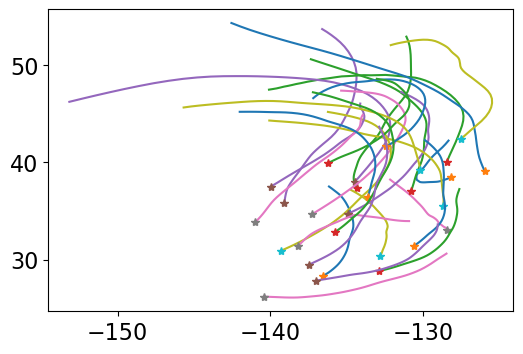

In [17]:
tdumpfiles = glob.glob('/home/disk/eos4/jkcm/Data/HYSPLIT/tdump/cset_profiles/cset_profile*')
fig, ax = plt.subplots()
for f in tdumpfiles:
    savefile = f'/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_{os.path.basename(f)[18:]}.nc'
    print(savefile)
    ds = traj.xarray_from_tdumpfile(f)
    print(np.nanmax(ds.lat))
#     ds = traj.make_trajectory(ds, save=False) 
    ax.plot(ds.lon, ds.lat)
    ax.plot(ds.lon[-1], ds.lat[-1], '*')

In [ ]:
prof_traj_data = xr.open_mfdataset('/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_*.nc', concat_dim=None)#, combine='nested')
prof_traj_data

In [18]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/profile_backtraj_20150722H1539.nc')

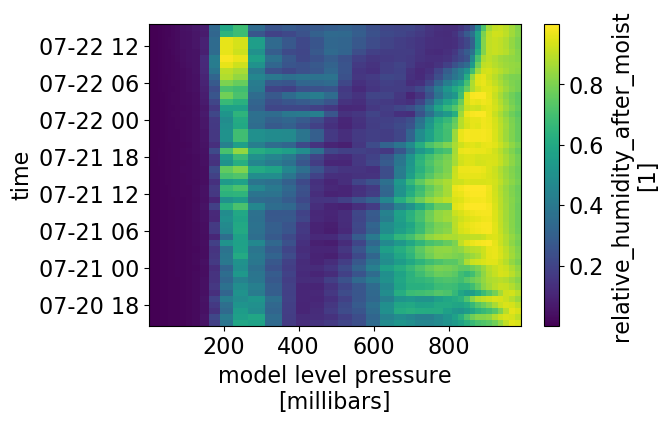

In [40]:
ds.MERRA_RH.plot()

In [ ]:
for varname, vardata in prof_traj_data.data_vars.items():
    vals = {}
    for prof in vardata.prof:
        data = vardata.sel(prof=prof)
        print(data.shape)
#     print(np.sum(~np.isnan(data.values.astype(float))))
#     print(data.shape)
#     print(f'{var}: {np.sum(~np.isnan(data.values.astype(float)))/len(data):0.0f}')

In [42]:
from pathlib import Path

region='sea'


#input data paths
data_dir = Path('/home/disk/eos4/jkcm/Data')
other_data_dir = Path('/home/disk/eos9/jkcm/Data')
if region=='nep':
    MERRA_dir = data_dir / 'MERRA' / '3h' / 'more_vertical'
    MERRA_fmt = "MERRA2_400.inst3_3d_aer_Nv.{:%Y%m%d}.nc4.nc4"
elif region=='sea':
    MERRA_dir = data_dir / 'MERRA' / 'sea' / 'new'
    MERRA_fmt = "MERRA2_400.inst3_3d_aer_Nv.{:%Y%m%d}.SUB.nc"

CSET_dir = data_dir / 'CSET'

MODIS_pbl_dayfile = CSET_dir / 'Ryan/Daily_1x1_JHISTO_CTH_c6_day_v2_calboxes_top10_Interp_hif_zb_2011-2016_corrected.nc'
MODIS_pbl_nightfile = CSET_dir / 'Ryan/Daily_1x1_JHISTO_CTH_c6_night_v2_calboxes_top10_Interp_hif_zb_2011-2016.nc'
SSMI_file_fmt = other_data_dir / 'ssmi/all/ssmi_unified_{}*.nc'
GOES_file_fmt = CSET_dir / 'GOES/VISST_pixel/G15V03.0.NH.{}{:03}.{}*.NC"







In [3]:
ac_data = []
traj_data = []

aircraft_prof_files = sorted(glob.glob('/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/aircraft_profile_*.nc'))
backtraj_files = sorted(glob.glob('/home/disk/eos4/jkcm/Data/CSET/profile_backtrajectories/new/profile_backtraj_*.nc'))
for ac, bt in zip(aircraft_prof_files, backtraj_files):
    assert ac.split('_')[-1][:-3] in bt
    ac_data.append(xr.open_dataset(ac))
    traj_data.append(xr.open_dataset(bt))

In [4]:
good_trajs = np.array([ 2,  8, 17, 24])


Text(0, 0.5, 'ERA5 $Z_i$ $(m)$\n')

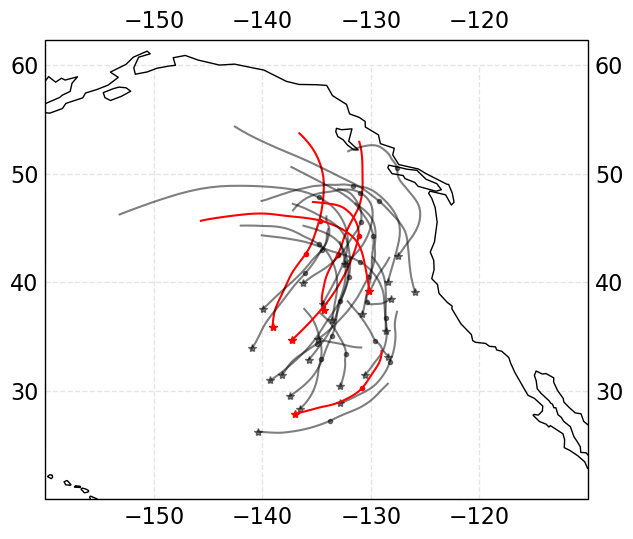

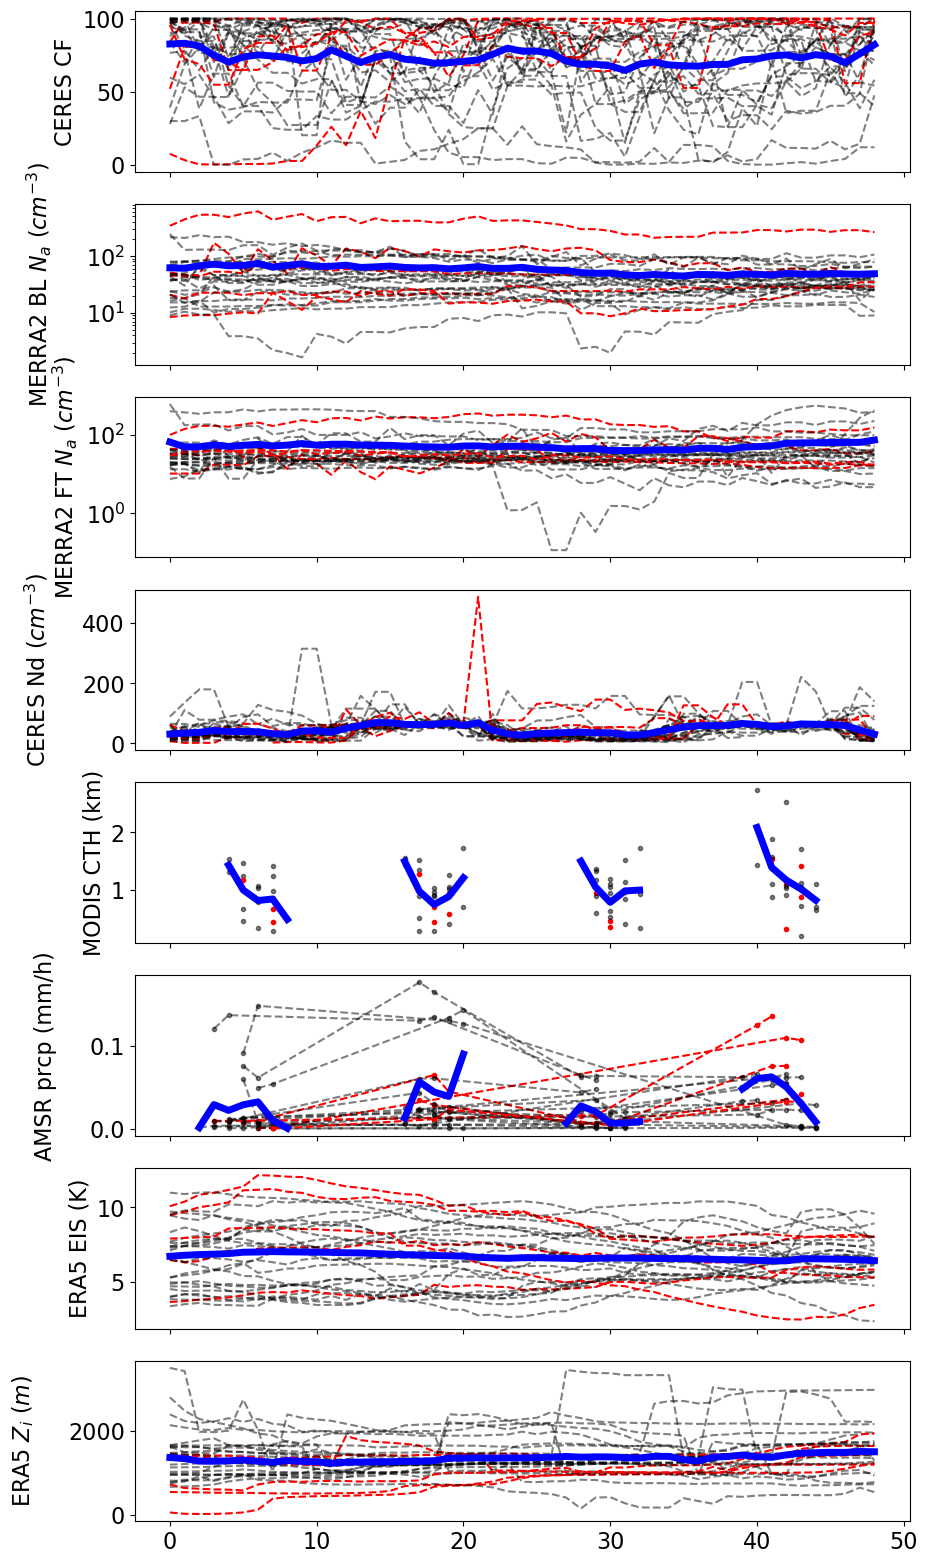

In [10]:
#CF along BT
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_xticks(np.arange(-160, -110, 5), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(20, 60, 5), crs=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.1, linestyle='--', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-160, -100, 10))
gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))
ax.set_extent([-160, -110, 20, 60])


fig, axg = plt.subplots(nrows=8, figsize=(10,20), sharex=True)
cf_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
na_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
na_ft_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
nd_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
cth_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
prcp_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
eis_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)
zi_vals = np.full(shape=(len(traj_data), 49), fill_value=np.nan)

for i, traj in enumerate(traj_data):
    if i in good_trajs:
        col='r'
        alph=1
    else:
        col='k'
        alph=0.5
        
    p = ax.plot(traj.lon, traj.lat, c=col, alpha=alph)
    ax.plot(traj.lon[-1], traj.lat[-1], '*', c=p[0].get_color(), alpha=alph)
    ax.plot(traj.lon[-25], traj.lat[-25], '.', c=p[0].get_color(), alpha=alph)
    
    axg[0].plot(traj.CERES_cldarea_low_1h.values, '--', c=col, alpha=alph)
    cf_vals[i,:] = traj.CERES_cldarea_low_1h.values
    
#     n_acc = traj.MERRA_acc_num.sel(lev=slice(800,1000)).mean(dim='lev').values/1e6*50
    n_acc = traj.MERRA_Na_tot.sel(lev=slice(900,1000)).mean(dim='lev').values
    axg[1].plot(n_acc, '--', c=col, alpha=alph)
    na_vals[i,:] = n_acc
    
    n_acc_ft = traj.MERRA_Na_tot.sel(lev=slice(650,750)).mean(dim='lev').values
    axg[2].plot(n_acc_ft, '--', c=col, alpha=alph)
    na_ft_vals[i,:] = n_acc_ft
    
    axg[3].plot(traj.CERES_Nd.values, '--', c=col, alpha=alph)
    nd_vals[i,:] = traj.CERES_Nd.values
    
    axg[4].plot(traj.MODIS_CTH.values, '--', c=col, marker='.', alpha=alph)
    cth_vals[i,:] = traj.MODIS_CTH.values
    
    axg[5].plot(np.where(~np.isnan(traj.AMSR_prcp_mean.values))[0], traj.AMSR_prcp_mean.values[~np.isnan(traj.AMSR_prcp_mean.values)], '--', c=col, marker='.', alpha=alph)
    prcp_vals[i,:] = traj.AMSR_prcp_mean.values
    
    axg[6].plot(traj.ERA_EIS.values, '--', c=col, alpha=alph)
    eis_vals[i,:] = traj.ERA_EIS.values
    
        
    
    inv = []
    for j in traj.time:
        try:
            inv_subs = traj.sel(time=j)
            z = inv_subs.ERA_z.values/9.81
            rh = inv_subs.ERA_r.values
            t = inv_subs.ERA_t.values
            p = inv_subs.level.values
            theta = met_utils.theta_from_p_T(p, t)
#             qi = met_utils.quick_inversion(z, t, p, smooth_t=False)
#             inv.append(qi['z_mid'])
            try:
                zi = met_utils.Peter_inv(z, rh, theta, polyfit_range=1)
            except IndexError as e:
                plt.figure()
                plt.plot(z, t)
                raise e
            inv.append(zi)
            

            
            
        except ValueError:
            inv.append(np.nan)
    
    axg[7].plot(inv, '--', c=col, alpha=alph)
    zi_vals[i,:] = np.array(inv)
    
        
    
meancol='b'
axg[0].plot(np.mean(cf_vals, axis=0), lw=5, c=meancol)
axg[0].set_ylabel('CERES CF')

axg[1].plot(np.mean(na_vals, axis=0), lw=5, c=meancol)
axg[1].set_ylabel('MERRA2 BL $N_{a}$ $(cm^{-3})$\n')
axg[1].set_yscale('log')

axg[2].plot(np.mean(na_ft_vals, axis=0), lw=5, c=meancol)
axg[2].set_ylabel('MERRA2 FT $N_{a}$ $(cm^{-3})$')
axg[2].set_yscale('log')


axg[3].plot(np.nanmean(nd_vals, axis=0), lw=5, c=meancol)
axg[3].set_ylabel('CERES Nd $(cm^{-3})$\n')

axg[4].plot(np.nanmean(cth_vals, axis=0), lw=5, c=meancol)
axg[4].set_ylabel('MODIS CTH (km)')


axg[5].plot(np.nanmean(prcp_vals, axis=0), lw=5, c=meancol)
axg[5].set_ylabel('AMSR prcp (mm/h)\n')


axg[6].plot(np.nanmean(eis_vals, axis=0), lw=5, c=meancol)
axg[6].set_ylabel('ERA5 EIS (K)')


axg[7].plot(np.nanmean(zi_vals, axis=0), lw=5, c=meancol)
axg[7].set_ylabel('ERA5 $Z_i$ $(m)$\n')

Text(0.5, 0.98, 'Means over both days')

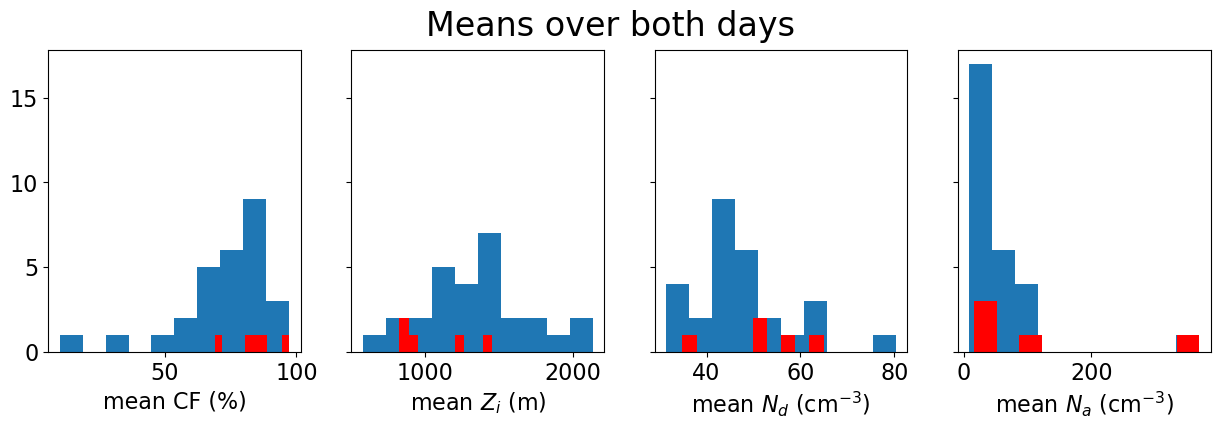

In [11]:
mean_cfs = np.nanmean(cf_vals[:,0:-1], axis=1)
mean_zis = np.nanmean(zi_vals[:,0:-1], axis=1)
mean_nds = np.nanmean(nd_vals[:,0:-1], axis=1)
mean_nas = np.nanmean(na_vals[:,0:-1], axis=1)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, figsize=(15,4), sharey=True)
ax1.hist(mean_cfs)
ax1.hist(mean_cfs[filt], color='r')
ax1.set_xlabel(r'mean CF (%)')
ax2.hist(mean_zis)
ax2.hist(mean_zis[filt], color='r')
ax2.set_xlabel(r'mean $Z_i$ (m)')
ax3.hist(mean_nds)
ax3.hist(mean_nds[filt], color='r')
ax3.set_xlabel(r'mean $N_d$ (cm$^{-3}$)')
ax4.hist(mean_nas)
ax4.hist(mean_nas[filt], color='r')
ax4.set_xlabel(r'mean $N_a$ (cm$^{-3}$)')

plt.suptitle('Means over both days')

Text(0.5, 0.98, 'Changes between first and last 4 hours of trajectory (2 days)')

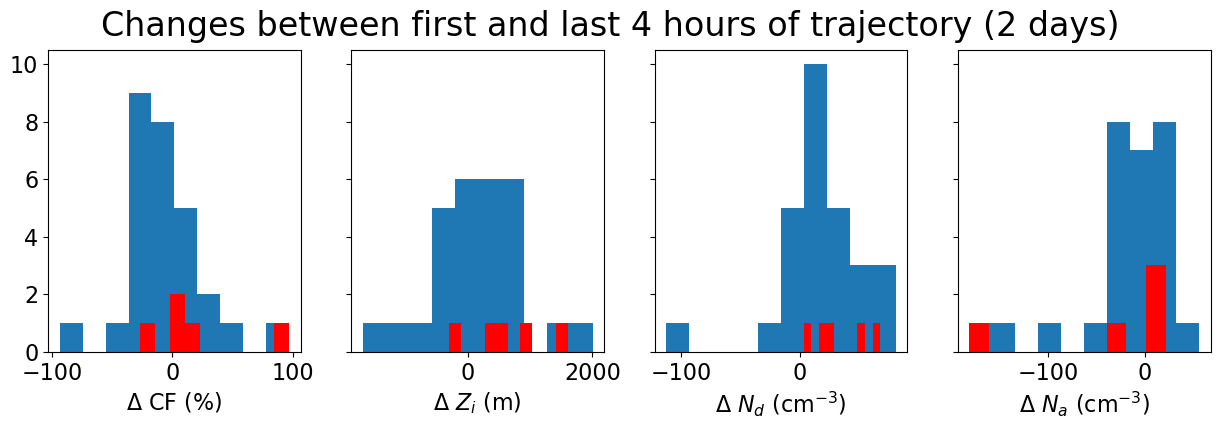

In [12]:
delta_cfs = np.nanmean(cf_vals[:,-4:-1], axis=1) - np.nanmean(cf_vals[:,0:4], axis=1)
delta_zis = np.nanmean(zi_vals[:,-4:-1], axis=1) - np.nanmean(zi_vals[:,0:4], axis=1)
delta_nds = np.nanmean(nd_vals[:,-4:-1], axis=1) - np.nanmean(nd_vals[:,0:4], axis=1)
delta_nas = np.nanmean(na_vals[:,-4:-1], axis=1) - np.nanmean(na_vals[:,0:4], axis=1)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, figsize=(15,4), sharey=True)
ax1.hist(delta_cfs)
ax1.hist(delta_cfs[filt], color='r')
ax1.set_xlabel(r'$\Delta$ CF (%)')
ax2.hist(delta_zis)
ax2.hist(delta_zis[filt], color='r')
ax2.set_xlabel(r'$\Delta$ $Z_i$ (m)')
ax3.hist(delta_nds)
ax3.hist(delta_nds[filt], color='r')
ax3.set_xlabel(r'$\Delta$ $N_d$ (cm$^{-3}$)')
ax4.hist(delta_nas)
ax4.hist(delta_nas[filt], color='r')
ax4.set_xlabel(r'$\Delta$ $N_a$ (cm$^{-3}$)')

plt.suptitle('Changes between first and last 4 hours of trajectory (2 days)')

Text(0.5, 0.98, 'Changes between middle and last 4 hours of trajectory (1 day)')

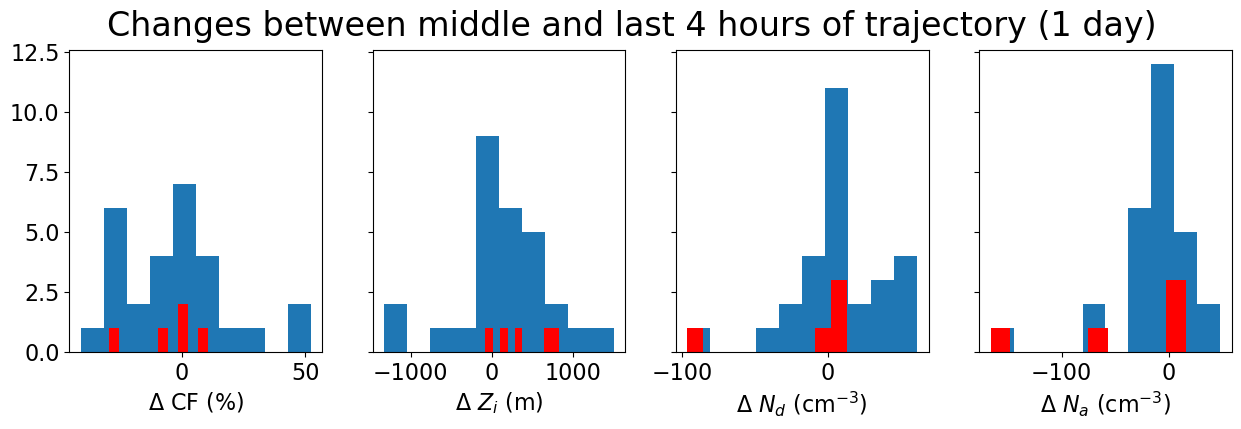

In [13]:
delta_cfs_1d = np.nanmean(cf_vals[:,-4:-1], axis=1) - np.nanmean(cf_vals[:,-28:-25], axis=1)
delta_zis_1d = np.nanmean(zi_vals[:,-4:-1], axis=1) - np.nanmean(zi_vals[:,-28:-25], axis=1)
delta_nds_1d = np.nanmean(nd_vals[:,-4:-1], axis=1) - np.nanmean(nd_vals[:,-28:-25], axis=1)
delta_nas_1d = np.nanmean(na_vals[:,-4:-1], axis=1) - np.nanmean(na_vals[:,-28:-25], axis=1)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, figsize=(15,4), sharey=True)
(n, bins, patches)= ax1.hist(delta_cfs_1d)
ax1.hist(delta_cfs_1d[filt], color='r')
ax1.set_xlabel(r'$\Delta$ CF (%)')
ax2.hist(delta_zis_1d)
ax2.hist(delta_zis_1d[filt], color='r')
ax2.set_xlabel(r'$\Delta$ $Z_i$ (m)')
ax3.hist(delta_nds_1d)
ax3.hist(delta_nds_1d[filt], color='r')
ax3.set_xlabel(r'$\Delta$ $N_d$ (cm$^{-3}$)')
ax4.hist(delta_nas_1d)
ax4.hist(delta_nas_1d[filt], color='r')
ax4.set_xlabel(r'$\Delta$ $N_a$ (cm$^{-3}$)')

plt.suptitle('Changes between middle and last 4 hours of trajectory (1 day)')

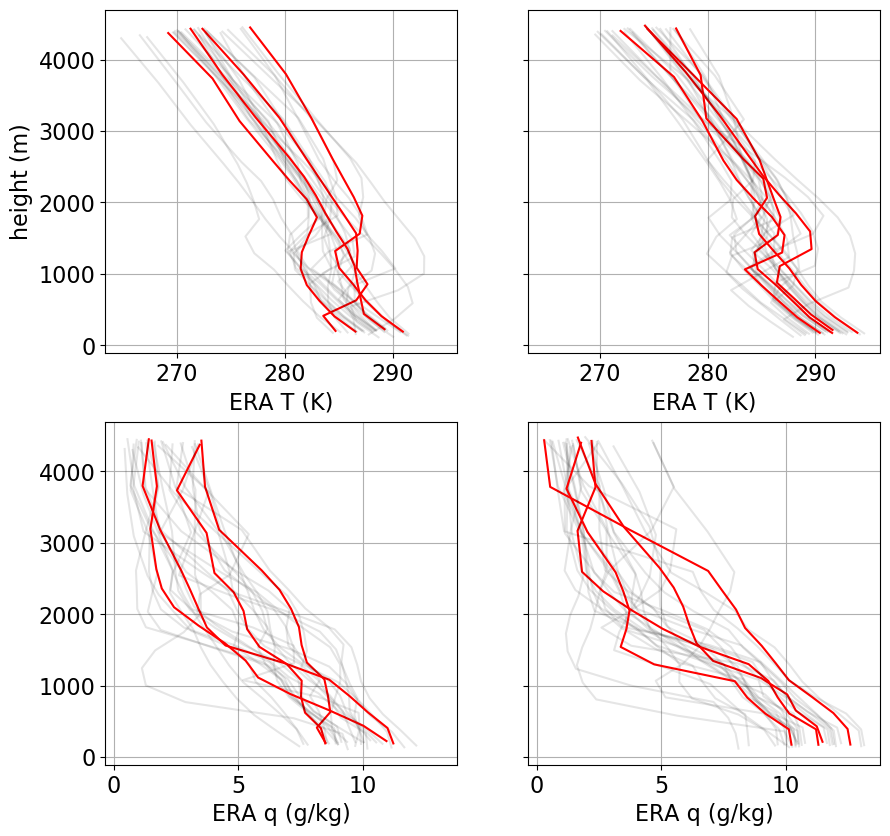

In [8]:
fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharey=True, sharex='row')
for i, traj in enumerate(traj_data):
    if i in good_trajs:
        col='r'
        alph=1
    else:
        col='k'
        alph=0.1
    
    p = ax.plot(traj.isel(time=0).sel(level=slice(600,1000)).ERA_t, traj.isel(time=0).sel(level=slice(600,1000)).ERA_z/9.81, c=col, alpha=alph)
    ax2.plot(traj.isel(time=-1).sel(level=slice(600,1000)).ERA_t, traj.isel(time=-1).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color(), alpha=alph)
    
    ax3.plot(traj.isel(time=0).sel(level=slice(600,1000)).ERA_q*1000, traj.isel(time=0).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color(), alpha=alph)
    ax4.plot(traj.isel(time=-1).sel(level=slice(600,1000)).ERA_q*1000, traj.isel(time=-1).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color(), alpha=alph)
    
ax.set_ylabel('height (m)')
ax.set_xlabel('ERA T (K)')
ax2.set_xlabel('ERA T (K)')
ax3.set_xlabel('ERA q (g/kg)')
ax4.set_xlabel('ERA q (g/kg)')
for axi in [ax, ax2, ax3, ax4]:
    axi.grid(True)

In [140]:
#filter cases
good_cf_filt = np.nanmin(cf_vals, axis=1)>50
good_zi_filt = np.nanmean(zi_vals[:, 0:24], axis=1)<1500
na_filt = mean_nas>100
filters = [good_cf_filt, good_zi_filt]
# filters = [na_filt]
filt = np.ufunc.reduce(np.logical_and, filters)
filt[1]=True
good_trajs = np.where(filt)[0]
good_trajs

array([ 1,  2,  8, 17, 24])

In [14]:
good_trajs = np.array([ 2, 8])
filt = np.full_like(delta_cfs, fill_value=False, dtype=bool); filt[good_trajs]=True
filt

array([False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [15]:
#all cf>50, first day < 1600m: 2, 8, 17, 24
#2 is good: lots of deepening under high stability, drop in aerosol without drop in droplet conc
#1 is great: travels down from the continent, high Na, moderate Nd, lots of deepening, big drop in Na
#8 is good: steady, with big decrease in Nd, moderate decrease in CF 
#17: big EIS decrease, moderate deepening

def case_info(i):
    print('=======================')
    print(f'case {i}, {os.path.basename(backtraj_files[i])[17:-3]}')
    print(f'starts at {traj_data[i].lat.values[0]:0.1f}N, {traj_data[i].lon.values[0]:0.1f}E')
    print(f'ends at {traj_data[i].lat.values[-1]:0.1f}N, {traj_data[i].lon.values[-1]:0.1f}E')
    print(f'delta-zi: {delta_zis_1d[i]:0.0f} m (from {np.nanmean(zi_vals[i,-28:-25]):0.0f} m to {np.nanmean(zi_vals[i,-4:-1]):0.0f} m)')
    print(f'delta-CF: {delta_cfs_1d[i]:0.0f} % (from {np.nanmean(cf_vals[i,-28:-25]):0.0f}% to {np.nanmean(cf_vals[i,-4:-1]):0.0f}%)')
    print(f'delta-Nd: {delta_nds_1d[i]:0.0f} /cc (from {np.nanmean(nd_vals[i,-28:-25]):0.0f} /cc to {np.nanmean(nd_vals[i,-4:-1]):0.0f} /cc)')
    print(f'delta-Na: {delta_nas_1d[i]:0.0f} /cc  (from {np.nanmean(na_vals[i,-28:-25]):0.0f} /cc to {np.nanmean(na_vals[i,-4:-1]):0.0f} /cc)')
    print(f'EIS from {np.nanmean(eis_vals[i,-28:-25]):0.1f} K to {np.nanmean(eis_vals[i,-4:-1]):0.1f} K')
for i in good_trajs:
    case_info(i)

case 2, 20150707H1750
starts at 53.7N, -136.6E
ends at 35.8N, -139.1E
delta-zi: 666 m (from 748 m to 1414 m)
delta-CF: -6 % (from 100% to 94%)
delta-Nd: 13 /cc (from 27 /cc to 41 /cc)
delta-Na: -74 /cc  (from 129 /cc to 55 /cc)
EIS from 9.6 K to 8.0 K
case 8, 20150717H1746
starts at 47.4N, -135.3E
ends at 34.7N, -137.2E
delta-zi: -78 m (from 1181 m to 1102 m)
delta-CF: -29 % (from 99% to 70%)
delta-Nd: -97 /cc (from 169 /cc to 73 /cc)
delta-Na: 2 /cc  (from 49 /cc to 51 /cc)
EIS from 7.5 K to 5.4 K


In [171]:
np.logspace(1,4,13)

array([   10.        ,    17.7827941 ,    31.6227766 ,    56.23413252,
         100.        ,   177.827941  ,   316.22776602,   562.34132519,
        1000.        ,  1778.27941004,  3162.27766017,  5623.4132519 ,
       10000.        ])

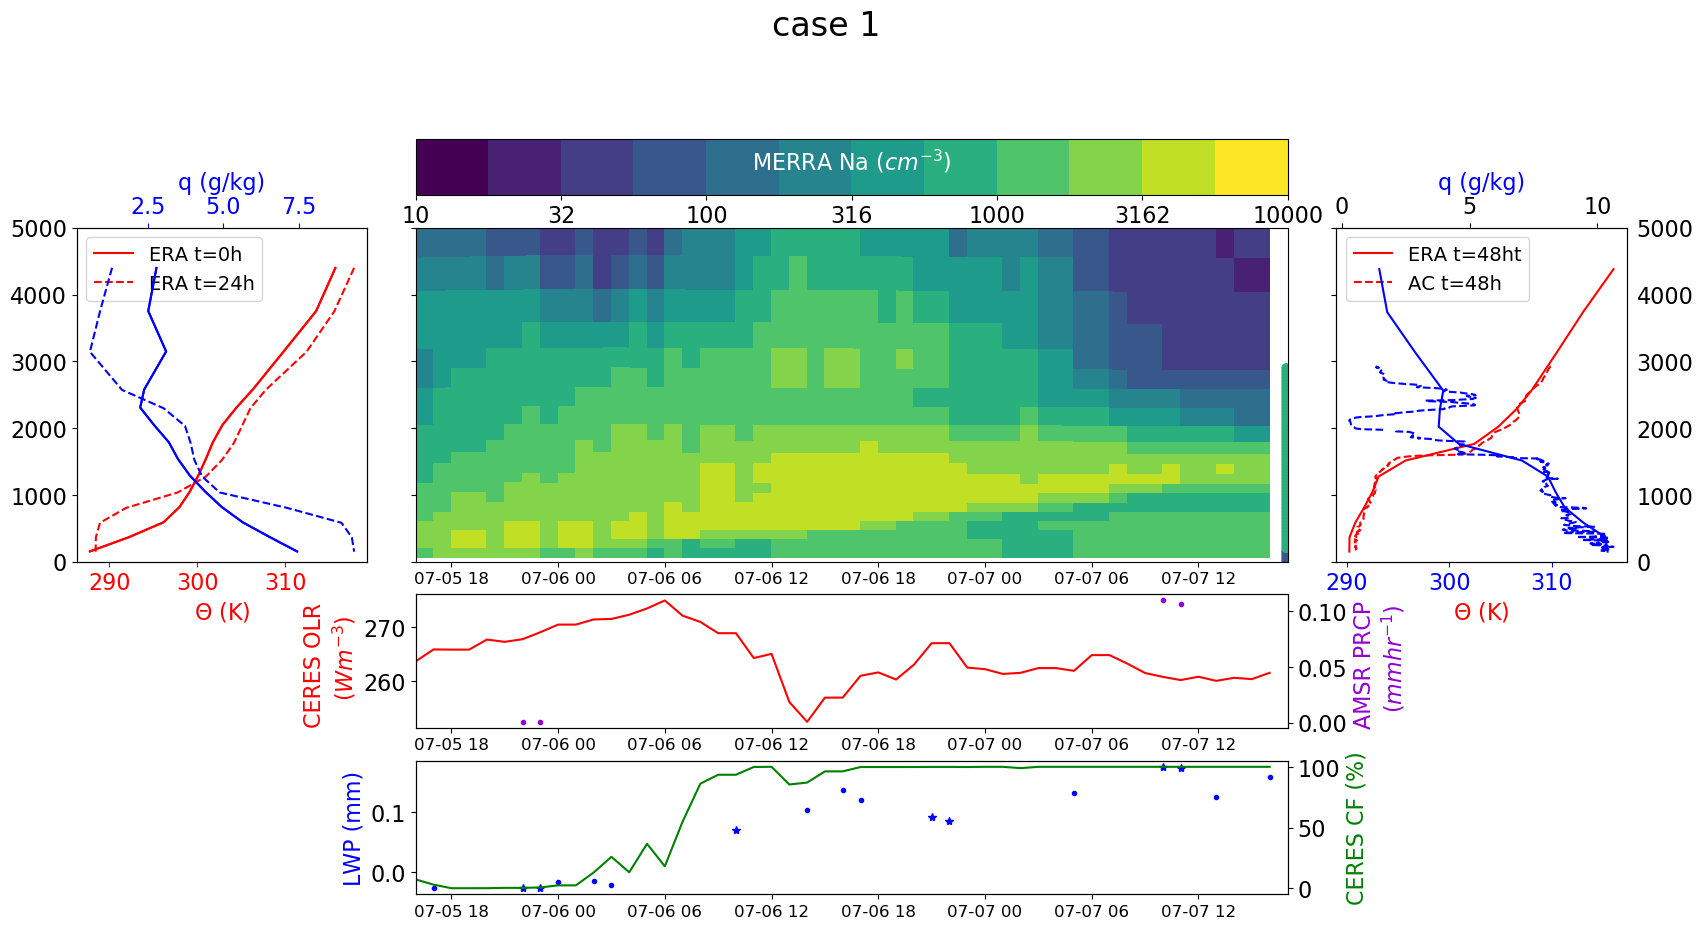

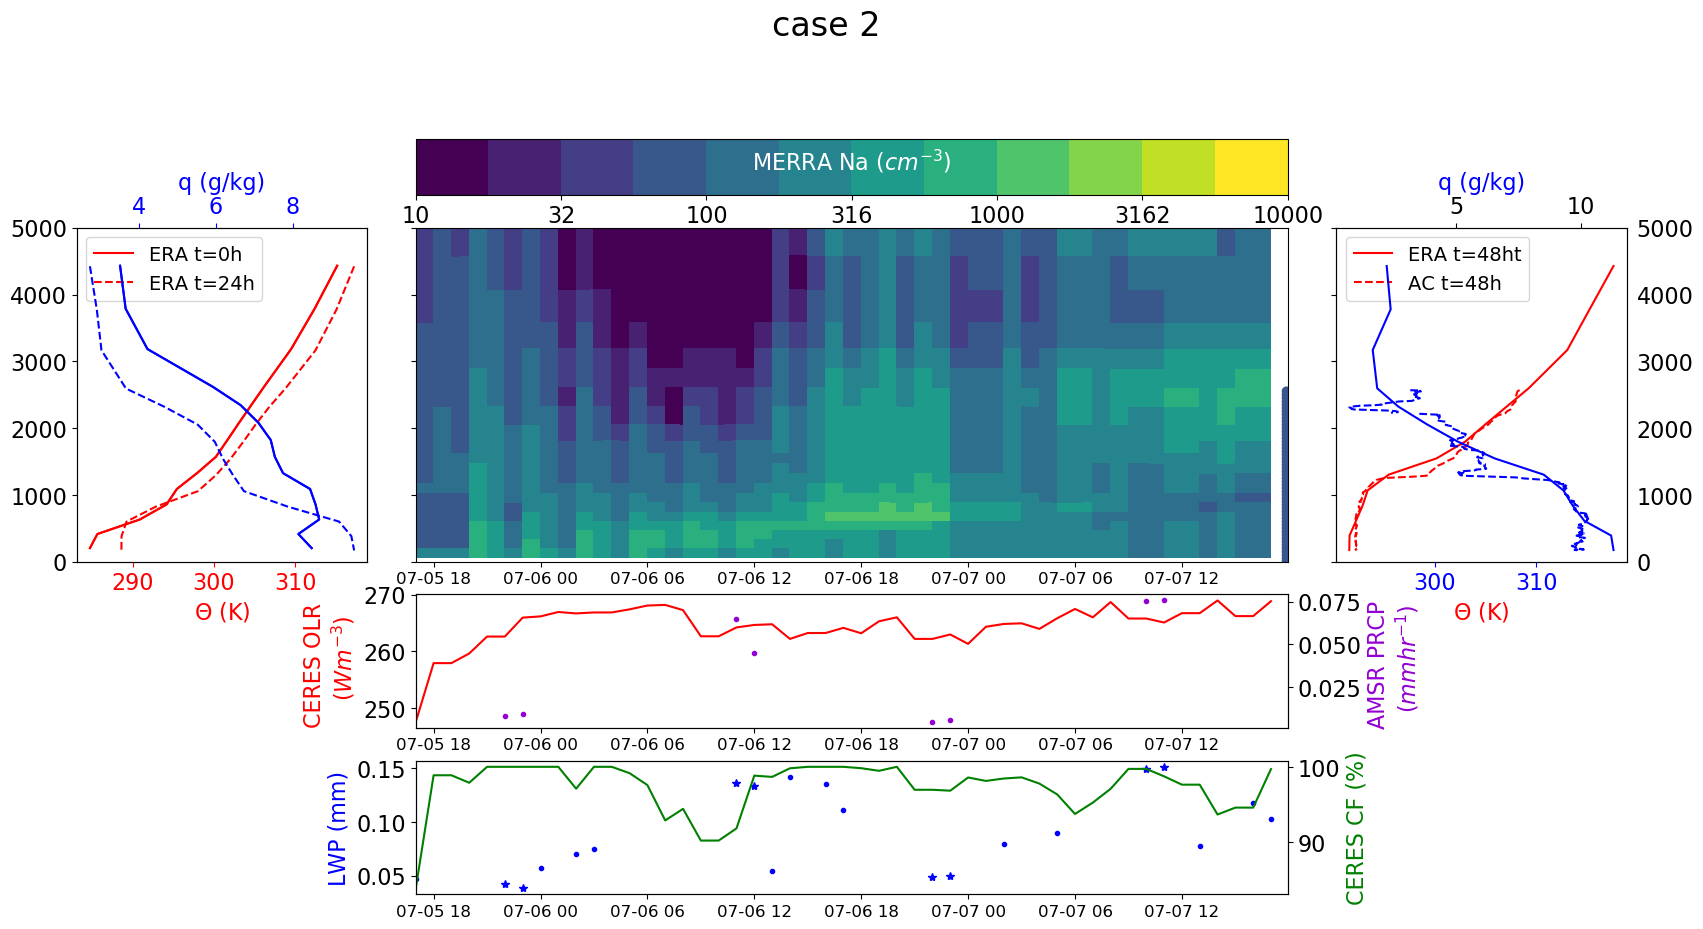

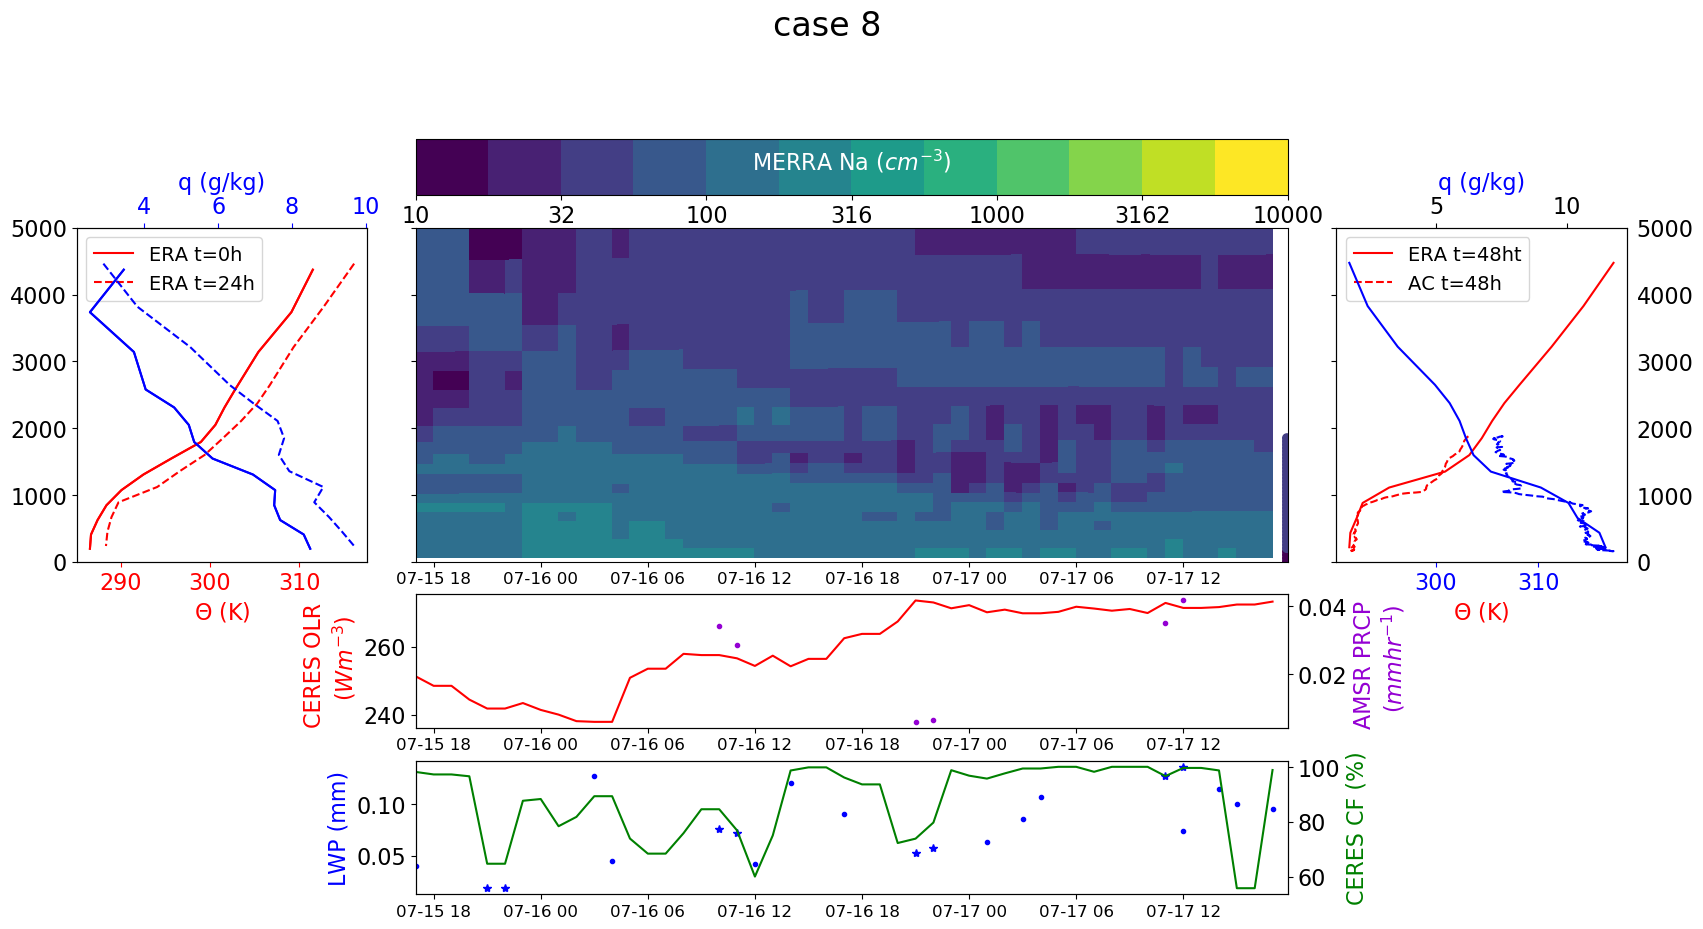

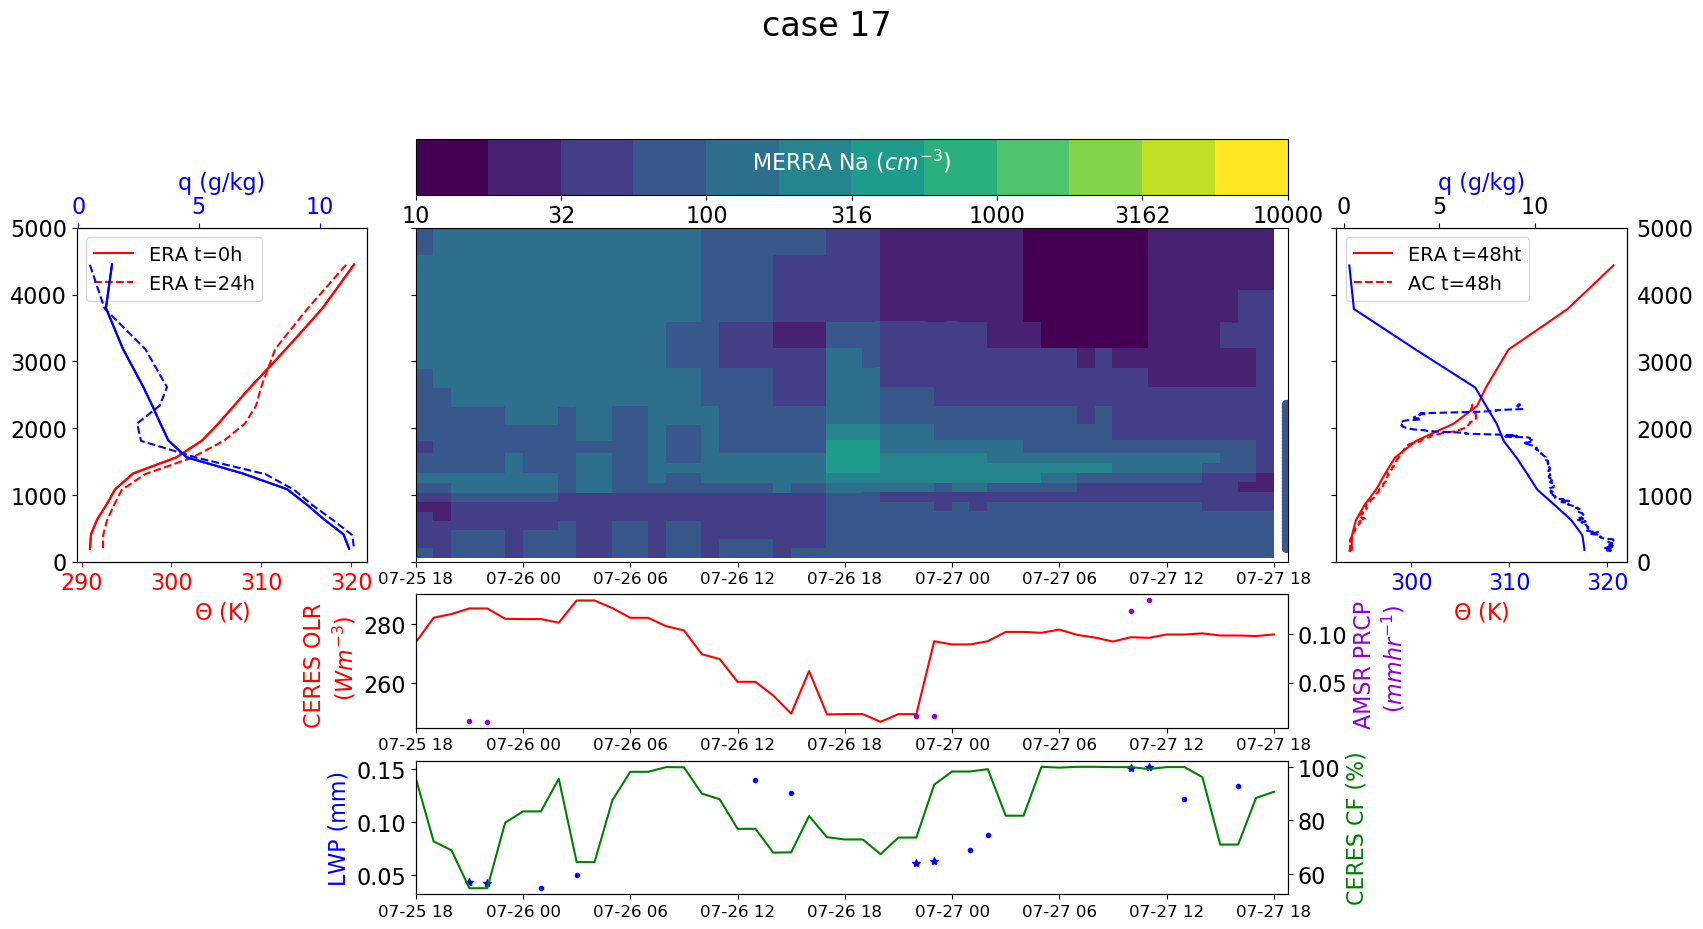

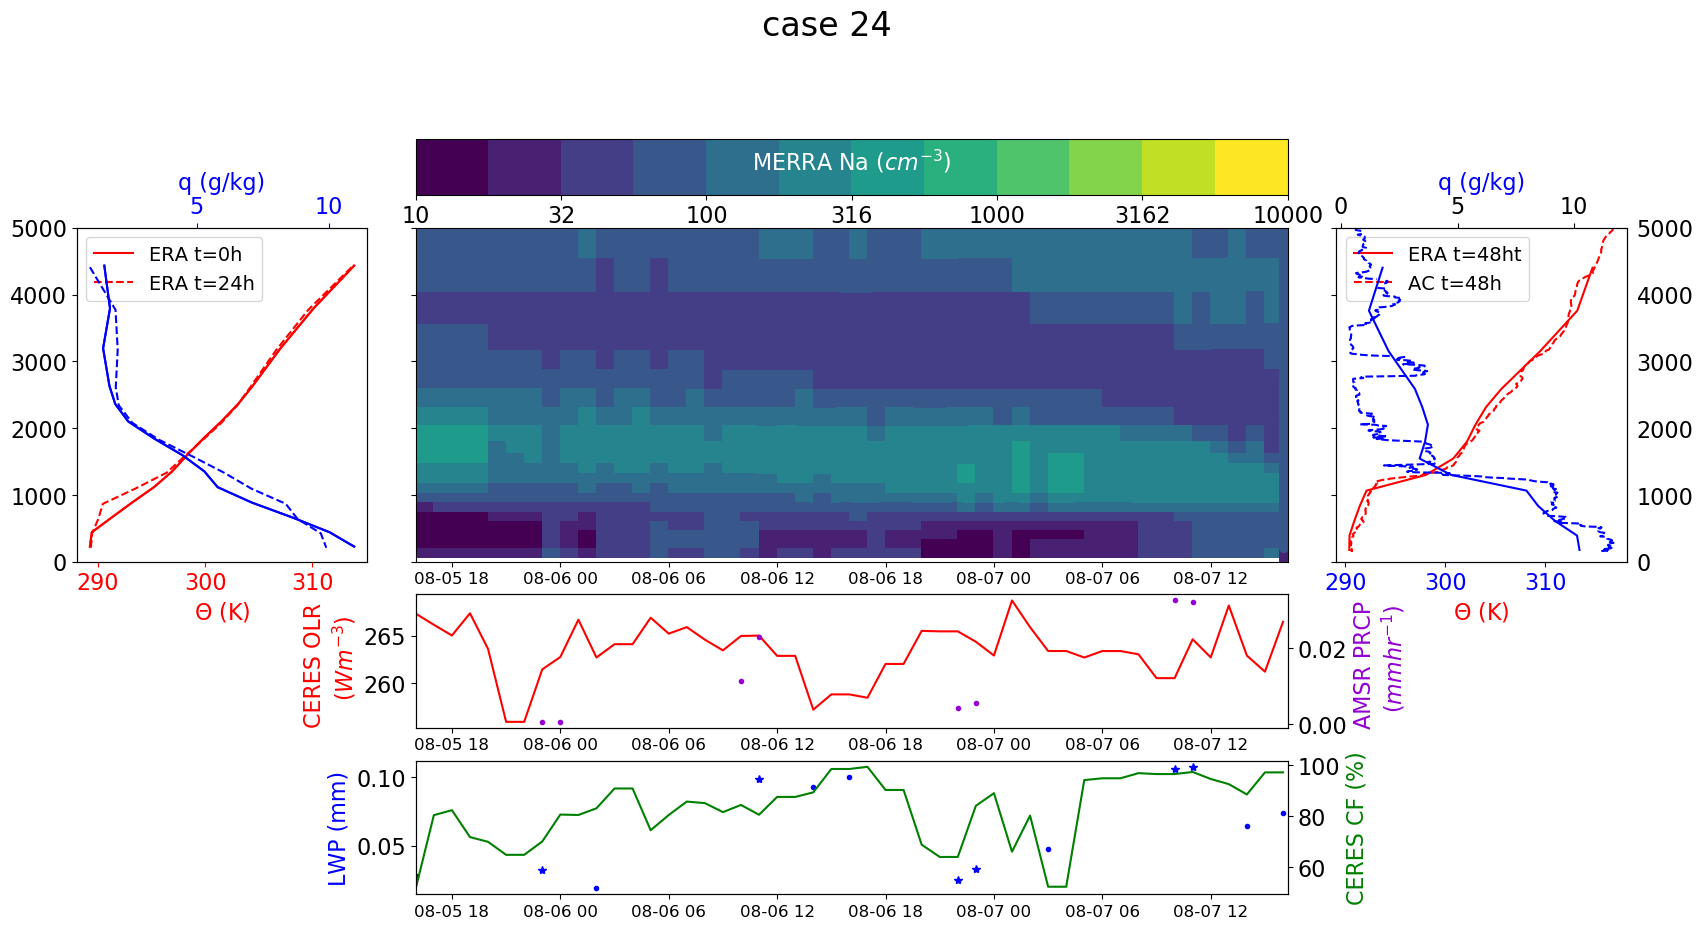

In [174]:
import matplotlib

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

def plot_case(ac_ds, traj_ds, i):
# if True:
#     i=1?
#     ac_ds, traj_ds = ac_data[i], traj_data[i]
    #3 panel: left is init profile (ERA), right is final profile (ERA and AC), both with double axis, q and T
    #middle panel is MERRA NA CORR color along traj
    #need to show that we have LWP as well
#     fig3 = plt.figure(figsize=(20,8))
#     gs = fig3.add_gridspec(6, 5)
#     axl_l = fig3.add_subplot(gs[1:4, 0])
#     axr_l = fig3.add_subplot(gs[1:4, -1])
#     axt = fig3.add_subplot(gs[:4, 1:4])
#     axb_l = fig3.add_subplot(gs[4:, 1:4])
    
    fig, [[ax5, cax, ax6], [axl_l, axt, axr_l], [ax1, axc_l, ax2], [ax3, axb_l, ax4]] = plt.subplots(
        nrows=4, ncols=3, figsize=(20,10),
        gridspec_kw={'width_ratios':[1,3,1], 'height_ratios': [0.5, 3,1.2,1.2], 'wspace':0.1})
    
    
    
    
    axl_r = axl_l.twiny()
    axr_r = axr_l.twiny()
    axb_r = axb_l.twinx()
    axc_r = axc_l.twinx()
    
    #add ERA to right side
    traj_ds['ERA_theta'] = met_utils.theta_from_p_T(traj_ds.level, traj_ds.ERA_t)
    ERA_end = traj_ds.sel(time=ac_ds.Time[0], method='nearest', tolerance=np.timedelta64(1, 'h'))
    end_low_idx = ERA_end.ERA_z/9.81 < 5000
    axr_l.plot(ERA_end.ERA_theta[end_low_idx], ERA_end.ERA_z[end_low_idx]/9.81, c='r', label='ERA t=48ht')
    axr_l.set_xlabel('$\Theta$ (K)', c='r')
    axr_l.tick_params(axis="x", colors='r')
    axr_r.plot(ERA_end.ERA_q[end_low_idx]*1000, ERA_end.ERA_z[end_low_idx]/9.81, c='b')
    axr_r.set_xlabel('q (g/kg)', c='b')
    
    ac_low_idx = ac_ds.GGALT<5000
    axr_l.plot(ac_ds.THETA[ac_low_idx], ac_ds.GGALT[ac_low_idx], c='r', ls='--', label='AC t=48h')
    axr_r.plot(ac_ds.MR[ac_low_idx], ac_ds.GGALT[ac_low_idx], c='b', ls='--')
    axr_l.tick_params(axis="x", colors='b')
#     axr_l.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    axr_l.legend(fontsize=14)
  
    
    
    
    ERA_start = traj_ds.isel(time=0)
    end_low_idx = ERA_start.ERA_z/9.81 < 5000
    axl_l.plot(ERA_start.ERA_theta[end_low_idx], ERA_start.ERA_z[end_low_idx]/9.81, c='r', label='ERA t=0h')
    axl_l.set_xlabel('$\Theta$ (K)', c='r')
    axl_l.tick_params(axis="x", colors='r')
    axl_r.plot(ERA_start.ERA_q[end_low_idx]*1000, ERA_start.ERA_z[end_low_idx]/9.81, c='b',)
    axl_r.set_xlabel('q (g/kg)', c='b')
    axl_r.tick_params(axis="x", colors='b')
    
    ERA_mid = traj_ds.isel(time=24)
    end_low_idx = ERA_mid.ERA_z/9.81 < 5000
    axl_l.plot(ERA_mid.ERA_theta[end_low_idx], ERA_mid.ERA_z[end_low_idx]/9.81, c='r', ls='--', label='ERA t=24h')
    axl_l.set_xlabel('$\Theta$ (K)', c='r')
    axl_r.plot(ERA_mid.ERA_q[end_low_idx]*1000, ERA_mid.ERA_z[end_low_idx]/9.81, ls='--', c='b')
    axl_r.set_xlabel('q (g/kg)', c='b')
    
#     axl_l.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    axl_l.legend(fontsize=14)
    
        
    ERA_start = traj_ds.isel(time=0)
    end_low_idx = ERA_start.ERA_z/9.81 < 5000
    axl_l.plot(ERA_start.ERA_theta[end_low_idx], ERA_start.ERA_z[end_low_idx]/9.81, c='r', label='ERA $\Theta$')
    axl_l.set_xlabel('$\Theta$ (K)', c='r')
    axl_r.plot(ERA_start.ERA_q[end_low_idx]*1000, ERA_start.ERA_z[end_low_idx]/9.81, c='b', label='ERA q')
    axl_r.set_xlabel('q (g/kg)', c='b')
    
    
    
#     traj_ds.MERRA_Na_tot_corr.plot(ax=axt, x='time', cbar_kwargs={'label': 'Na corr (cm-3)'})
    
    lognorm = colors.LogNorm(vmin=1, vmax=1e4)
    lognorm = colors.BoundaryNorm(boundaries=np.logspace(1,4,13), ncolors=256)
    
    
    pc = axt.pcolormesh(np.tile(traj_ds.time.T, (72, 1)).T, traj_ds.MERRA_H.values, traj_ds.MERRA_Na_tot_corr.values,
                  shading='nearest', norm=lognorm)
    
    cb=plt.colorbar(pc, orientation='horizontal', cax=cax, label='MERRA Na ($cm^{-3}$)')
    cax.set_title('MERRA Na ($cm^{-3}$)', y=0.3, c='w')
#     vmin, vmax = pc.get_clim()    
    
    ac_concs = np.interp(np.arange(0,np.nanmax(ac_ds.GGALT.values),50), ac_ds.GGALT.values, ac_ds.CONCU100_RWOOU.values)
#     ac_times = np.interp(np.arange(0,5000,50), ac_ds.GGALT.values, ac_ds.CONCU100_RWOOU.values)
    axt.scatter(x=[ac_ds.Time.values[100]]*len(ac_concs), 
                               y=np.arange(0,np.nanmax(ac_ds.GGALT.values),50), c=ac_concs, norm=lognorm)
    
#     axt.scatter(x=ac_ds.Time.values[ac_ds.GGALT<5000], y=ac_ds.GGALT[ac_ds.GGALT<5000], c=ac_ds.CONCU100_RWOOU[ac_ds.GGALT<5000],
#                vmin=vmin, vmax=vmax)
    
#     axt.invert_yaxis()
    axt.set_ylim(0,5000)

    
    
    axc_l.plot(traj_ds.time, traj_ds.CERES_toa_lw_all_1h, c='r')
    axc_l.set_ylabel('CERES OLR \n ($W m^{-3}$)', c='r')
    
    axc_r.plot(traj_ds.time, traj_ds.AMSR_prcp_mean, marker='.', lw=0, c='darkviolet')
    axc_r.set_ylabel('AMSR PRCP \n ($mm hr^{-1}$)', c='darkviolet')
    
    axb_l.plot(traj_ds.time, traj_ds.SSMI_LWP, 'b.', label='SSMI lwp')
    axb_l.plot(traj_ds.time, traj_ds.AMSR_LWP, 'b*', label='AMSR lwp')
    axb_l.set_ylabel('LWP (mm)', c='b')
    
    axb_r.plot(traj_ds.time, traj_ds.CERES_cldarea_low_1h, c='g')
    axb_r.set_ylabel('CERES CF (%)', c='g')
    plt.suptitle(f'case {i}', y=1.01)
    
    for axi in [ax1, ax2, ax3, ax4, ax5, ax6]:
        axi.axis('off')

    
    for axi in [axl_l, axt, axr_l]:
        axi.set_ylim([0, 5000])
        
    for axi in [axt, axc_l, axb_l]:
        axi.xaxis.set_tick_params(labelsize=12)
    
    for axi in [axt, axc_l, axb_l]:
        axi.set_xlim([np.nanmin(traj_ds.time), np.nanmax(ac_ds.Time)])

    axt.yaxis.set_tick_params(labelleft=False)
    axr_l.yaxis.set_tick_params(labelleft=False)
    axr_l.yaxis.set_tick_params(labelright=True)

#     for axy in [axr_r, axc_l, axc_r, axb_l, axb_r]:
# #         for tk in axy.get_yticklabels():
# #             tk.set_visible(True)
#         axy.yaxis.set_tick_params(labelleft=True)

#     for axx in [axt]:
#         for tk in axx.get_xticklabels():
#             tk.set_visible(True)
    

    
#     plt.tight_layout()

    return fig
    
    
for i in good_trajs:
    ac_ds, traj_ds = ac_data[i], traj_data[i]
    fig = plot_case(ac_ds, traj_ds, i)
    fig.savefig(f'/home/disk/p/jkcm/plots/mcb/case{i:02}_summary.png', bbox_inches='tight')


In [153]:
ac_ds.Time

<xarray.DataArray 'Time' (Time: 397)>
array(['2015-07-07T16:54:11.000000000', '2015-07-07T16:54:12.000000000',
       '2015-07-07T16:54:13.000000000', ..., '2015-07-07T17:00:45.000000000',
       '2015-07-07T17:00:46.000000000', '2015-07-07T17:00:47.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2015-07-07T16:54:11 ... 2015-07-07T17:00:47
Attributes:
    long_name:        time of measurement
    standard_name:    time
    strptime_format:  seconds since %F %T %z

In [37]:
traj_ds.time.T

<xarray.DataArray 'time' (time: 49)>
array(['2015-07-05T17:00:00.000000000', '2015-07-05T18:00:00.000000000',
       '2015-07-05T19:00:00.000000000', '2015-07-05T20:00:00.000000000',
       '2015-07-05T21:00:00.000000000', '2015-07-05T22:00:00.000000000',
       '2015-07-05T23:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-06T01:00:00.000000000', '2015-07-06T02:00:00.000000000',
       '2015-07-06T03:00:00.000000000', '2015-07-06T04:00:00.000000000',
       '2015-07-06T05:00:00.000000000', '2015-07-06T06:00:00.000000000',
       '2015-07-06T07:00:00.000000000', '2015-07-06T08:00:00.000000000',
       '2015-07-06T09:00:00.000000000', '2015-07-06T10:00:00.000000000',
       '2015-07-06T11:00:00.000000000', '2015-07-06T12:00:00.000000000',
       '2015-07-06T13:00:00.000000000', '2015-07-06T14:00:00.000000000',
       '2015-07-06T15:00:00.000000000', '2015-07-06T16:00:00.000000000',
       '2015-07-06T17:00:00.000000000', '2015-07-06T18:00:00.000000000',
       '2015-0

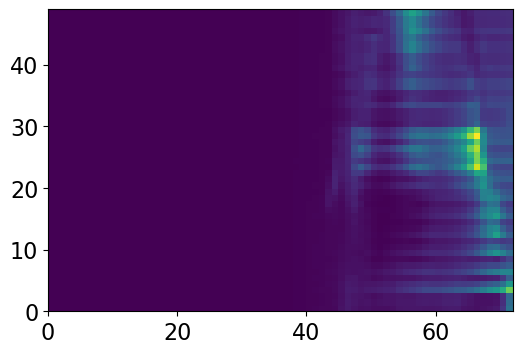

In [50]:
plt.pcolormesh(traj_ds.MERRA_Na_tot_corr.values)

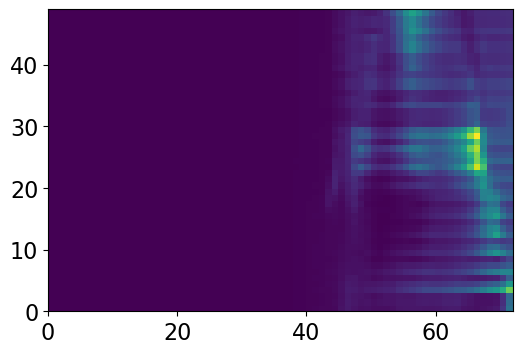

In [51]:

    plt.pcolormesh(traj_ds.MERRA_Na_tot_corr.values,
                  shading='nearest')

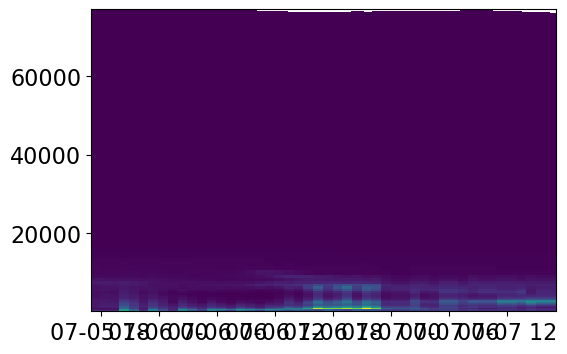

In [63]:

    plt.pcolormesh(np.tile(traj_ds.time.T, (72, 1)).T, traj_ds.MERRA_H.values, traj_ds.MERRA_Na_tot_corr.values,
                  shading='nearest')

In [62]:
help(plt.pcolormesh)

Help on function pcolormesh in module matplotlib.pyplot:

pcolormesh(*args, alpha=None, norm=None, cmap=None, vmin=None, vmax=None, shading='flat', antialiased=False, data=None, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolor([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. note::
    
       ``pcolormesh()`` is similar to :func:`~Axes.pcolor`. It's much
       faster and preferred in most cases. For a detailed discussion on
       the differences see
       :ref:`Differences between pcolor() and pcolormesh()
       <differences-pcolor-pcolormesh>`.
    
    Parameters
    ----------
    C : array_like
        A scalar 2-D array. The values will be color-mapped.
    
    X, Y : array_like, optional
        The coordinates of the quadrilateral corners. The quadrilateral
        for ``C[i,j]`` has corners at::
    
            (X[i+1, j], Y[i+1, j])   

TypeError: Image data of dtype datetime64[ns] cannot be converted to float

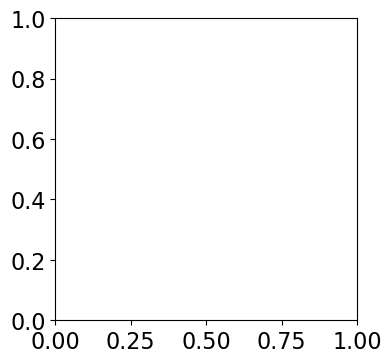

In [40]:
plt.imshow(np.tile(traj_ds.time.T, (72, 1)).T)

In [25]:
traj_ds.MERRA_H.values.shape

(49, 72)

In [26]:
traj_ds.MERRA_Na_tot_corr.values.shape

(49, 72)

Text(0, 0.5, 'ERA5 $Z_i$ $(m)$\n')

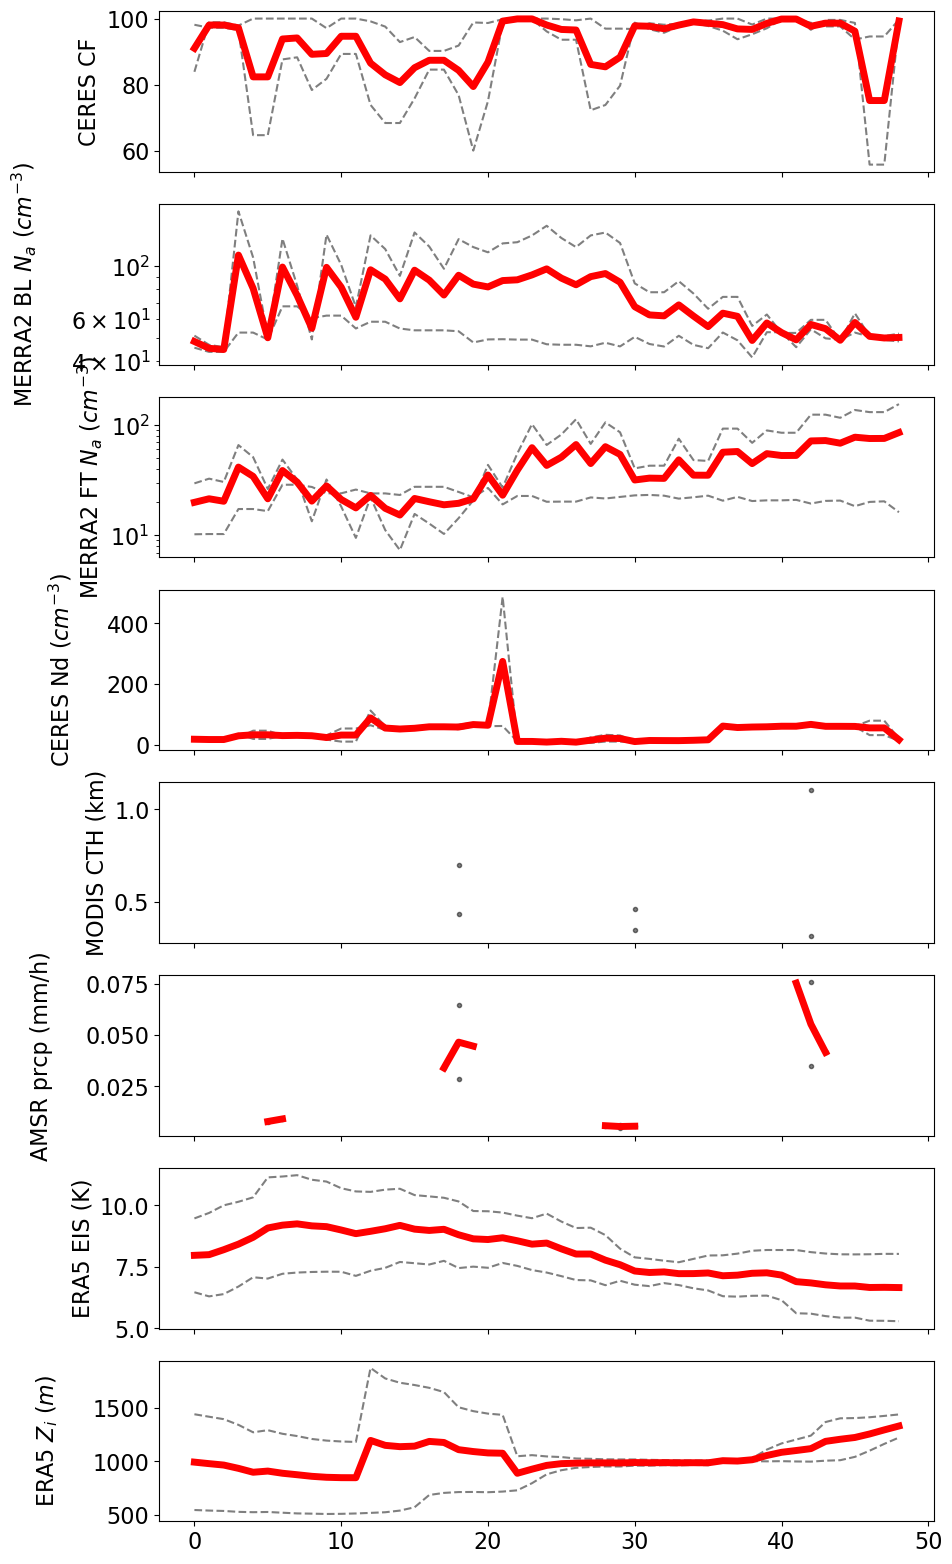

In [18]:

fig, axg = plt.subplots(nrows=8, figsize=(10,20), sharex=True)
cf_vals_filt = cf_vals[filt]
na_vals_filt = na_vals[filt]
na_ft_vals_filt = na_ft_vals[filt]
nd_vals_filt = nd_vals[filt]
cth_vals_filt = cth_vals[filt]
prcp_vals_filt = prcp_vals[filt]
eis_vals_filt = eis_vals[filt]
zi_vals_filt = zi_vals[filt]

for i, traj in enumerate(traj_data):
    if i not in np.where(filt)[0]:
        continue
    p = ax.plot(traj.lon, traj.lat)
    ax.plot(traj.lon[-1], traj.lat[-1], '*', c=p[0].get_color())
    ax.plot(traj.lon[-25], traj.lat[-25], '.', c=p[0].get_color())
    
    axg[0].plot(traj.CERES_cldarea_low_1h.values, 'k--', alpha=0.5)
    
#     n_acc = traj.MERRA_acc_num.sel(lev=slice(800,1000)).mean(dim='lev').values/1e6*50
    n_acc = traj.MERRA_Na_tot.sel(lev=slice(900,1000)).mean(dim='lev').values
    axg[1].plot(n_acc, 'k--', alpha=0.5)
    
    n_acc_ft = traj.MERRA_Na_tot.sel(lev=slice(650,750)).mean(dim='lev').values
    axg[2].plot(n_acc_ft, 'k--', alpha=0.5)
    
    axg[3].plot(traj.CERES_Nd.values, 'k--', alpha=0.5)
    
    axg[4].plot(traj.MODIS_CTH.values, 'k--', marker='.', alpha=0.5)
    
    axg[5].plot(traj.AMSR_prcp_mean.values, 'k--', lw=0, marker='.', alpha=0.5)
    
    axg[6].plot(traj.ERA_EIS.values, 'k--', alpha=0.5)
    
    axg[7].plot(zi_vals[i], 'k--', alpha=0.5)
    
axg[0].plot(np.mean(cf_vals_filt, axis=0), lw=5, c='r')
axg[0].set_ylabel('CERES CF')

axg[1].plot(np.mean(na_vals_filt, axis=0), lw=5, c='r')
axg[1].set_ylabel('MERRA2 BL $N_{a}$ $(cm^{-3})$\n')
axg[1].set_yscale('log')

axg[2].plot(np.mean(na_ft_vals_filt, axis=0), lw=5, c='r')
axg[2].set_ylabel('MERRA2 FT $N_{a}$ $(cm^{-3})$')
axg[2].set_yscale('log')


axg[3].plot(np.nanmean(nd_vals_filt, axis=0), lw=5, c='r')
axg[3].set_ylabel('CERES Nd $(cm^{-3})$\n')

axg[4].plot(np.nanmean(cth_vals_filt, axis=0), lw=5, c='r')
axg[4].set_ylabel('MODIS CTH (km)')


axg[5].plot(np.nanmean(prcp_vals_filt, axis=0), lw=5, c='r')
axg[5].set_ylabel('AMSR prcp (mm/h)\n')


axg[6].plot(np.nanmean(eis_vals_filt, axis=0), lw=5, c='r')
axg[6].set_ylabel('ERA5 EIS (K)')


axg[7].plot(np.nanmean(zi_vals_filt, axis=0), lw=5, c='r')
axg[7].set_ylabel('ERA5 $Z_i$ $(m)$\n')


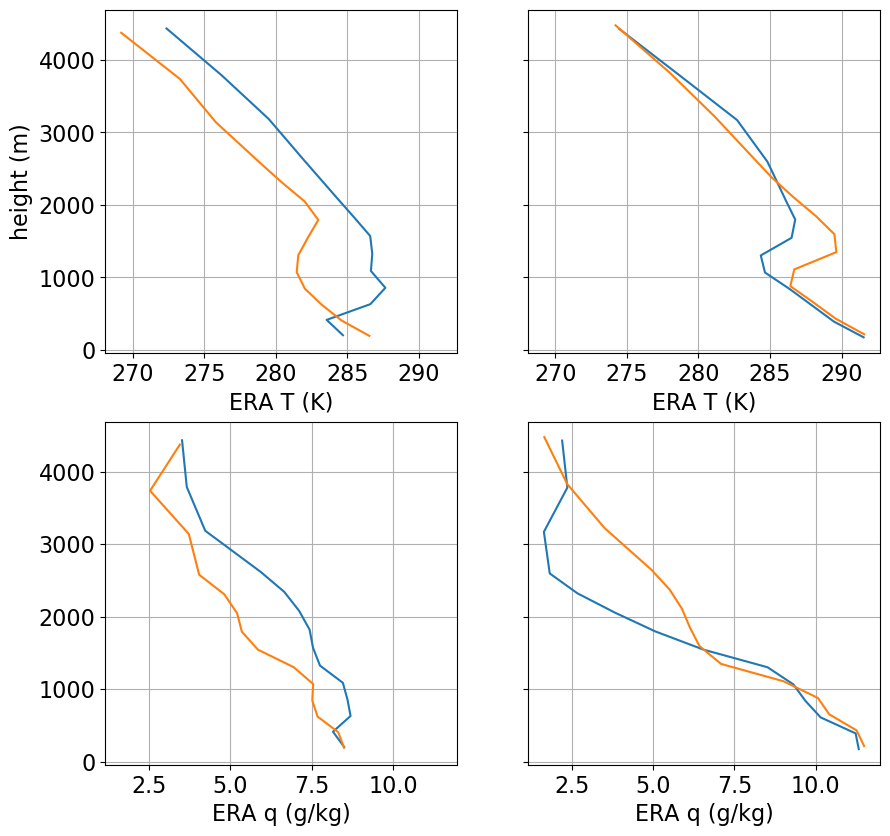

In [19]:
fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharey=True, sharex='row')
for i, traj in enumerate(traj_data):
    if i not in np.where(filt)[0]:
        continue
    p = ax.plot(traj.isel(time=0).sel(level=slice(600,1000)).ERA_t, traj.isel(time=0).sel(level=slice(600,1000)).ERA_z/9.81)
    ax2.plot(traj.isel(time=-1).sel(level=slice(600,1000)).ERA_t, traj.isel(time=-1).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color())
    
    ax3.plot(traj.isel(time=0).sel(level=slice(600,1000)).ERA_q*1000, traj.isel(time=0).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color())
    ax4.plot(traj.isel(time=-1).sel(level=slice(600,1000)).ERA_q*1000, traj.isel(time=-1).sel(level=slice(600,1000)).ERA_z/9.81, c=p[0].get_color())
    
ax.set_ylabel('height (m)')
ax.set_xlabel('ERA T (K)')
ax2.set_xlabel('ERA T (K)')
ax3.set_xlabel('ERA q (g/kg)')
ax4.set_xlabel('ERA q (g/kg)')
for axi in [ax, ax2, ax3, ax4]:
    axi.grid(True)

In [20]:
np.where(filt)

(array([2, 8]),)